### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

### Generating batches

In [2]:
batch1 = pickle.load(open('data/batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [3]:
numBat1 = len(batch1.keys())
numBat1

41

In [4]:
batch2 = pickle.load(open('data/batch2.pkl','rb'))

In [5]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482]

In [6]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [7]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [8]:
numBat2 = len(batch2.keys())
numBat2

43

In [9]:
batch3 = pickle.load(open('data/batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [10]:
numBat3 = len(batch3.keys())
numBat3

40

In [11]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [12]:
bat_dict = {**batch1, **batch2, **batch3}

Text(0, 0.5, 'Discharge Capacity (Ah)')

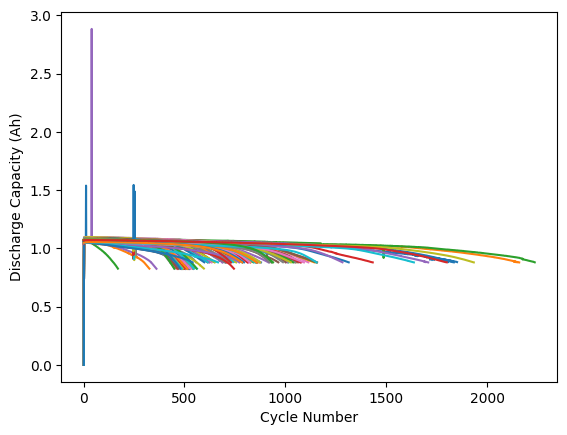

In [42]:
for i in bat_dict.keys():
    plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

In [82]:
#Train and test indices
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat)

### KDD

In [95]:
# Summary data: IR - Battery internal resistance
#           QC - Charge capacity (Ah)
#           QD - Discharge capacity (Ah)
#           Tavg - Average Temperature in a given cycle(°C)
#           Tmin - Min Temperature in a given cycle(°C)
#           Tmax - Max Temperature in a given cycle(°C)
#           chargetime - Charge time in a given cycle
batch1['b1c0']['summary'].keys()

dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])

In [96]:
# Cycle data: I - Current (A) 
#             t - Time
#             T - Temperature
#             V - Voltage (V)
#             Qc - Charge capacity (Ah)
#             Qd - Discharge capacity (Ah)
#             Qdlin - Linearly interpolated discharge capacity
#             dQdV - Derived vectors of discharge
#             Tdlin - Linearly interpolated temperature
batch1['b1c0']['cycles']['0'].keys()

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])

In [100]:
# Creating the feature q100_10, that is the difference between the capacity discharge in cycle 100 and cycle 10
for i in bat_dict.keys():
    q10 = bat_dict[i]['cycles']['10']['Qd']
    q100 = bat_dict[i]['cycles']['100']['Qd']
    
    # Pad the smaller array with zeros and complete the subtraction
    res_size = max(len(q10), len(q100))
    q10 = np.pad(q10, (0, res_size - len(q10)), 'constant')
    q100 = np.pad(q100, (0, res_size - len(q100)), 'constant')
    
    q100_10 = q100 - q10
    bat_dict[i]['summary']['q100_10'] = q100_10

In [103]:
bat_dict['b1c3']['summary']['q100_10']

array([0.       , 0.       , 0.       , ..., 1.0846678, 1.0846678,
       1.0846678])

In [105]:
count = 0
for i in bat_dict.keys():
    if count >= 124:
        break
    voltage_curve = bat_dict[i]['cycles']['100']['V']
    q100_10_curve = bat_dict[i]['summary']['q100_10']
    
    plt.plot(q100_10_curve, 
    